In [1]:
from chexnet import get_chexnet_model
from keras.layers import Input, Dense, Dropout
from keras.utils import print_summary
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
import pandas as pd
from generator import AugmentedImageSequence
from test_CheXNet import target_classes
#from weights import get_class_weights

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
from chexnet import get_chexnet_model

In [5]:
def get_3class_model():
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()

    x = base_model.output
    # Dropout layer
    #x = Dropout(0.2)(x)
    # one more layer (relu)
#     x = Dense(512, activation='relu')(x)

    predictions = Dense(
        3,
        activation="sigmoid")(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=None,
        decay=0.0,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    return base_model, model

In [6]:
base_model, model = get_3class_model()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [58]:
#Defining paths
# TRAIN_PATH = "../Covid-19-Detection/CovidDataset/Train"
# VAL_PATH = "../Covid-19-Detection/CovidDataset/Val"
TRAIN_PATH = "../chest_xray/train"
VAL_PATH = "../chest_xray/test"

In [59]:
#Moulding train images
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [62]:
#Reshaping test and validation images 
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')

Found 5328 images belonging to 3 classes.
Found 654 images belonging to 3 classes.


In [63]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

In [25]:
from sklearn.utils import class_weight

In [23]:
y_train = np.array([0]*112 + [1]*1341 + [2]*3875)
len(y_train)

5328

In [26]:
# Calculate the weights for each class so that we can balance the data
weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)

In [27]:
weights

array([15.85714286,  1.32438479,  0.45832258])

In [36]:
opt = Adam(
    lr=0.0001,
    beta_1=0.9,
    beta_2=0.999,
#     epsilon=None,
    decay=0.0,
    amsgrad=False
)
# for layer in model.layers:
#     layer.trainable = True

# Let's train the model using Adam
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
hist = model.fit_generator(train_generator,steps_per_epoch=8,epochs = 10,validation_data = validation_generator,
    validation_steps=2,class_weight=weights)

Epoch 1/10
8/8 [==============================] - 21s 3s/step - loss: 0.7857 - accuracy: 0.3348 - val_loss: 0.7447 - val_accuracy: 0.3492
Epoch 2/10
8/8 [==============================] - 4s 501ms/step - loss: 0.7466 - accuracy: 0.3523 - val_loss: 0.7202 - val_accuracy: 0.4550
Epoch 3/10
8/8 [==============================] - 7s 818ms/step - loss: 0.7124 - accuracy: 0.4964 - val_loss: 0.6803 - val_accuracy: 0.6508
Epoch 4/10
8/8 [==============================] - 7s 850ms/step - loss: 0.6728 - accuracy: 0.6521 - val_loss: 0.6458 - val_accuracy: 0.6772
Epoch 5/10
8/8 [==============================] - 6s 784ms/step - loss: 0.6457 - accuracy: 0.6870 - val_loss: 0.6375 - val_accuracy: 0.6561
Epoch 6/10
8/8 [==============================] - 6s 802ms/step - loss: 0.6238 - accuracy: 0.6652 - val_loss: 0.6130 - val_accuracy: 0.7037
Epoch 7/10
8/8 [==============================] - 6s 797ms/step - loss: 0.6061 - accuracy: 0.6754 - val_loss: 0.5838 - val_accuracy: 0.7354
Epoch 8/10
8/8 [======

In [107]:
from utils import eval, plot_training_metrics

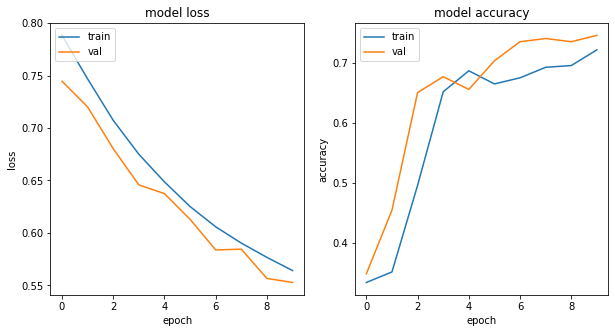

In [42]:
plot_training_metrics(hist)

In [52]:
cn = eval(model)

In [53]:
cn

array([[21,  9],
       [28,  2]])

In [55]:
y_actual, y_test = [],[]
path = VAL_PATH
for i in os.listdir(path + "/Normal/"):
    img=image.load_img(path + "/Normal/"+i,target_size=(224,224))
    img=image.img_to_array(img)/255.0
    img=np.expand_dims(img,axis=0)
    # pred=model.predict_classes(img)
    pred=model.predict(img)
    y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
    y_actual.append(1)


for i in os.listdir(path + "/Covid/"):
    img=image.load_img(path + "/Covid/"+i,target_size=(224,224))
    img=image.img_to_array(img)/255.0
    img=np.expand_dims(img,axis=0)
    # pred=model.predict_classes(img)
    pred=model.predict(img)
    y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
    y_actual.append(0)

for i in os.listdir(path + "/Pneumonia/"):
    img=image.load_img(path + "/Pneumonia/"+i,target_size=(224,224))
    img=image.img_to_array(img)/255.0
    img=np.expand_dims(img,axis=0)
    # pred=model.predict_classes(img)
    pred=model.predict(img)
    y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
    y_actual.append(2)

y_actual=np.array(y_actual)
y_test=np.array(y_test)

In [56]:
y_actual, y_test

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]))

In [72]:
y_train = train_generator.classes
print('Total datapoints: ', len(y_train))
print(train_generator.class_indices)
print('Class wise: ')
y = np.bincount(y_train)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

Total datapoints:  5328
{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}
Class wise: 


array([[   0,  112],
       [   1, 1341],
       [   2, 3875]])

In [73]:
y_train = validation_generator.classes
print('Total datapoints in validation set: ', len(y_train))
print(train_generator.class_indices)
print('Class wise: ')
y = np.bincount(y_train)
ii = np.nonzero(y)[0]
np.vstack((ii,y[ii])).T

Total datapoints in validation set:  654
{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}
Class wise: 


array([[  0,  30],
       [  1, 234],
       [  2, 390]])

In [85]:
base_model, model = get_3class_model()
opt = Adam(lr=0.001, beta_1=0.9,beta_2=0.999,decay=0.0,amsgrad=False)
# for layer in model.layers:
#     layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [86]:
weights

array([15.85714286,  1.32438479,  0.45832258])

In [87]:
hist = model.fit_generator(train_generator,steps_per_epoch=150,epochs = 10,validation_data = validation_generator,
    validation_steps=21,class_weight=weights)

Epoch 1/10
150/150 [==============================] - 315s 2s/step - loss: 0.3753 - accuracy: 0.8267 - val_loss: 0.2481 - val_accuracy: 0.7309
Epoch 2/10
150/150 [==============================] - 273s 2s/step - loss: 0.2692 - accuracy: 0.8988 - val_loss: 0.3206 - val_accuracy: 0.7314
Epoch 3/10
150/150 [==============================] - 291s 2s/step - loss: 0.2539 - accuracy: 0.9048 - val_loss: 0.3634 - val_accuracy: 0.7355
Epoch 4/10
150/150 [==============================] - 282s 2s/step - loss: 0.2326 - accuracy: 0.9135 - val_loss: 0.3009 - val_accuracy: 0.7604
Epoch 5/10
150/150 [==============================] - 267s 2s/step - loss: 0.2230 - accuracy: 0.9196 - val_loss: 0.3981 - val_accuracy: 0.7390
Epoch 6/10
150/150 [==============================] - 267s 2s/step - loss: 0.2122 - accuracy: 0.9207 - val_loss: 0.2411 - val_accuracy: 0.7396
Epoch 7/10
150/150 [==============================] - 266s 2s/step - loss: 0.2024 - accuracy: 0.9254 - val_loss: 0.4618 - val_accuracy: 0.7554

In [91]:
print(hist.history)

{'val_loss': [0.24811942875385284, 0.32060733437538147, 0.363361656665802, 0.3009353280067444, 0.3981182277202606, 0.24112890660762787, 0.4617972671985626, 0.7308357954025269, 0.39454174041748047, 0.5838127136230469], 'val_accuracy': [0.7308868765830994, 0.7313965559005737, 0.7354739904403687, 0.7604485154151917, 0.7390418648719788, 0.7395514249801636, 0.7553516626358032, 0.7395514845848083, 0.7553516626358032, 0.7400611639022827], 'loss': [0.37530940542618435, 0.26933024158613794, 0.2541272910342966, 0.2327665708535491, 0.22318053255511766, 0.21220861037572225, 0.2027732981088568, 0.20232506395383024, 0.2024890769983215, 0.19546140491165045], 'accuracy': [0.8267359, 0.8987695, 0.9048216, 0.91353124, 0.9195932, 0.9206945, 0.9253762, 0.92530674, 0.9227285, 0.92885995]}


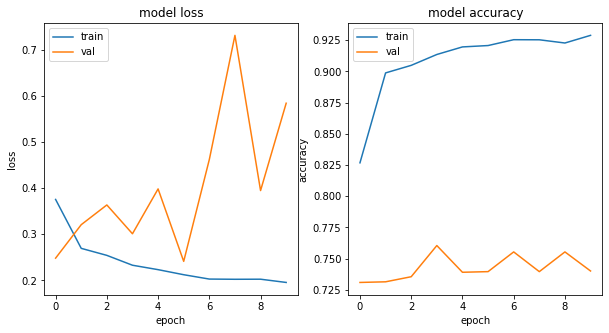

In [92]:
plot_training_metrics(hist)

In [ ]:
model.save("model_3c_e4_fc_train.h5")

In [93]:
cn=eval(model, path=VAL_PATH)
cn

array([[ 30,   0],
       [234,   0]])

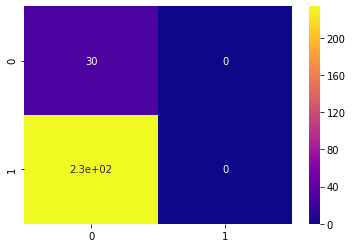

In [94]:
sns.heatmap(cn,cmap="plasma",annot=True) #0: Covid ; 1: Normal

In [95]:
hist2 = model.fit_generator(train_generator,steps_per_epoch=150,epochs = 10,validation_data = validation_generator,
    validation_steps=21,class_weight=weights)

Epoch 1/10
150/150 [==============================] - 289s 2s/step - loss: 0.1928 - accuracy: 0.9294 - val_loss: 0.5236 - val_accuracy: 0.7370
Epoch 2/10
150/150 [==============================] - 266s 2s/step - loss: 0.1900 - accuracy: 0.9293 - val_loss: 0.4236 - val_accuracy: 0.7477
Epoch 3/10
150/150 [==============================] - 258s 2s/step - loss: 0.1911 - accuracy: 0.9281 - val_loss: 0.4279 - val_accuracy: 0.7513
Epoch 4/10
150/150 [==============================] - 254s 2s/step - loss: 0.1876 - accuracy: 0.9306 - val_loss: 0.6320 - val_accuracy: 0.7640
Epoch 5/10
150/150 [==============================] - 258s 2s/step - loss: 0.1852 - accuracy: 0.9295 - val_loss: 0.5676 - val_accuracy: 0.7518
Epoch 6/10
150/150 [==============================] - 253s 2s/step - loss: 0.1842 - accuracy: 0.9321 - val_loss: 0.3915 - val_accuracy: 0.7396
Epoch 7/10
150/150 [==============================] - 252s 2s/step - loss: 0.1820 - accuracy: 0.9302 - val_loss: 0.9105 - val_accuracy: 0.7380

In [96]:
model.save("model_3c_e4_fc_train_20ep.h5")

In [97]:
base_model, model = get_3class_model()
opt = Adam(lr=0.001, beta_1=0.9,beta_2=0.999,decay=0.0,amsgrad=False)
# for layer in model.layers:
#     layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [98]:
hist4 = model.fit_generator(train_generator,steps_per_epoch=150,epochs = 10,validation_data = validation_generator,
    validation_steps=21,class_weight=weights)

Epoch 1/10
150/150 [==============================] - 292s 2s/step - loss: 0.3744 - accuracy: 0.8322 - val_loss: 0.4001 - val_accuracy: 0.7309
Epoch 2/10
150/150 [==============================] - 254s 2s/step - loss: 0.2806 - accuracy: 0.8944 - val_loss: 0.3250 - val_accuracy: 0.7360
Epoch 3/10
150/150 [==============================] - 253s 2s/step - loss: 0.2476 - accuracy: 0.9080 - val_loss: 0.3979 - val_accuracy: 0.7467
Epoch 4/10
150/150 [==============================] - 252s 2s/step - loss: 0.2332 - accuracy: 0.9176 - val_loss: 0.4791 - val_accuracy: 0.7416
Epoch 5/10
150/150 [==============================] - 260s 2s/step - loss: 0.2139 - accuracy: 0.9225 - val_loss: 0.2488 - val_accuracy: 0.7370
Epoch 6/10
150/150 [==============================] - 266s 2s/step - loss: 0.2114 - accuracy: 0.9186 - val_loss: 0.3204 - val_accuracy: 0.7457
Epoch 7/10
150/150 [==============================] - 258s 2s/step - loss: 0.2099 - accuracy: 0.9219 - val_loss: 0.9669 - val_accuracy: 0.7482

In [99]:
for layer in model.layers:
    layer.trainable = True

In [100]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [101]:
opt = Adam(lr=0.0001, beta_1=0.9,beta_2=0.999,decay=0.0,amsgrad=False)
# for layer in model.layers:
#     layer.trainable = True

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [102]:
hist3 = model.fit_generator(train_generator,steps_per_epoch=150,epochs = 20,validation_data = validation_generator,
    validation_steps=21,class_weight=weights)

Epoch 1/20
150/150 [==============================] - 292s 2s/step - loss: 0.1566 - accuracy: 0.9452 - val_loss: 0.6431 - val_accuracy: 0.8818
Epoch 2/20
150/150 [==============================] - 271s 2s/step - loss: 0.1140 - accuracy: 0.9603 - val_loss: 0.0507 - val_accuracy: 0.9322
Epoch 3/20
150/150 [==============================] - 267s 2s/step - loss: 0.0978 - accuracy: 0.9652 - val_loss: 0.1474 - val_accuracy: 0.9439
Epoch 4/20
150/150 [==============================] - 269s 2s/step - loss: 0.0854 - accuracy: 0.9684 - val_loss: 0.0461 - val_accuracy: 0.9460
Epoch 5/20
150/150 [==============================] - 271s 2s/step - loss: 0.0732 - accuracy: 0.9757 - val_loss: 0.1840 - val_accuracy: 0.9343
Epoch 6/20
150/150 [==============================] - 273s 2s/step - loss: 0.0630 - accuracy: 0.9790 - val_loss: 0.1522 - val_accuracy: 0.9439
Epoch 7/20
150/150 [==============================] - 259s 2s/step - loss: 0.0596 - accuracy: 0.9787 - val_loss: 0.0387 - val_accuracy: 0.9353

In [105]:
model.save("model_3c_e4_all_train.h5")

In [114]:
def eval2(model, path=VAL_PATH):
    y_actual, y_test = [],[]
    for i in os.listdir(path + "/Normal/"):
        img=image.load_img(path + "/Normal/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
        y_actual.append(1)


    for i in os.listdir(path + "/Covid/"):
        img=image.load_img(path + "/Covid/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
        y_actual.append(0)
    
    for i in os.listdir(path + "/Pneumonia/"):
        img=image.load_img(path + "/Pneumonia/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_test.append(np.argmax(pred[0]))
#         if pred[0,1]>=0.5:
#             y_test.append(1)
#         else:
#             y_test.append(0)
#         # y_test.append(pred[0,0])
        y_actual.append(2)
        
    y_actual=np.array(y_actual)
    y_test=np.array(y_test)
    cn=confusion_matrix(y_actual,y_test)
    return cn, y_actual, y_test

In [115]:
cn,y_actual,y_test=eval2(model, path=VAL_PATH)

In [118]:
cn=confusion_matrix(y_actual,y_test)
cn

array([[ 26,   3,   1],
       [  0, 233,   1],
       [  1,  68, 321]])

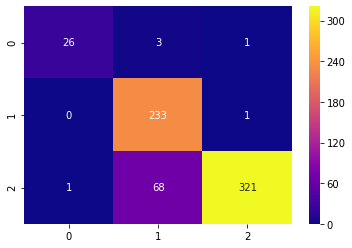

In [119]:
sns.heatmap(cn,cmap="plasma",annot=True, fmt='g') #0: Covid ; 1: Normal

In [126]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

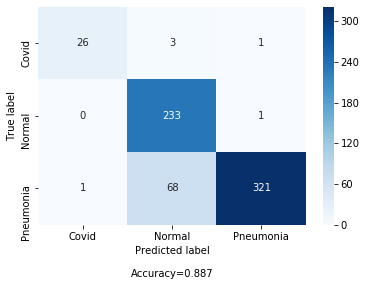

In [136]:
categories = ['Covid', 'Normal', 'Pneumonia']
make_confusion_matrix(cn, categories=categories,percent=False)

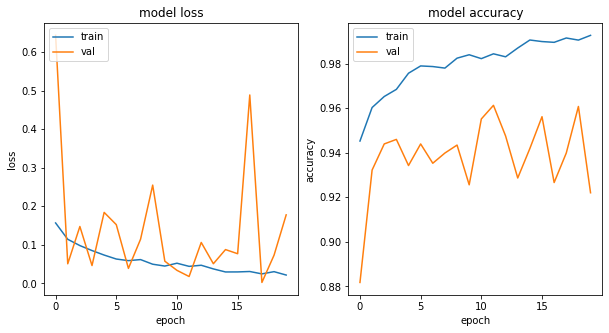

In [120]:
plot_training_metrics(hist3)

# Tuning hyperparameters further and store best model

In [137]:
checkpoint = ModelCheckpoint("models/3class_best.hdf5",
            monitor='val_loss',verbose=1,save_best_only=True,mode='auto',period=1)

In [138]:
hist5 = model.fit_generator(train_generator,steps_per_epoch=150,epochs = 40,validation_data = validation_generator,
    validation_steps=21,class_weight=weights,callbacks=[checkpoint],initial_epoch=30)

Epoch 31/40
150/150 [==============================] - 269s 2s/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.4523 - val_accuracy: 0.9332

Epoch 00031: val_loss improved from inf to 0.45227, saving model to models/3class_best.hdf5
Epoch 32/40
150/150 [==============================] - 248s 2s/step - loss: 0.0271 - accuracy: 0.9900 - val_loss: 0.0635 - val_accuracy: 0.9551

Epoch 00032: val_loss improved from 0.45227 to 0.06348, saving model to models/3class_best.hdf5
Epoch 33/40
150/150 [==============================] - 254s 2s/step - loss: 0.0238 - accuracy: 0.9919 - val_loss: 0.3387 - val_accuracy: 0.9353

Epoch 00033: val_loss did not improve from 0.06348
Epoch 34/40
150/150 [==============================] - 255s 2s/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0074 - val_accuracy: 0.9404

Epoch 00034: val_loss improved from 0.06348 to 0.00737, saving model to models/3class_best.hdf5
Epoch 35/40
150/150 [==============================] - 272s 2s/step - loss: 0.0215 - 

In [139]:
cn2,y_actual,y_test=eval2(model, path=VAL_PATH)

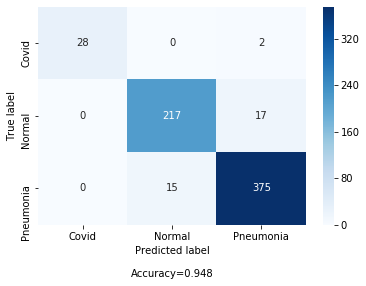

In [140]:
make_confusion_matrix(cn2, categories=categories,percent=False)

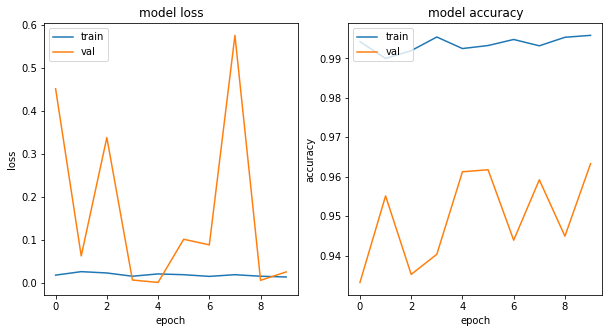

In [141]:
plot_training_metrics(hist5)

In [146]:
_, best_model = get_3class_model()

In [147]:
best_model.load_weights("models/3class_best.hdf5")

In [148]:
cn_best,_,_=eval2(best_model, path=VAL_PATH)

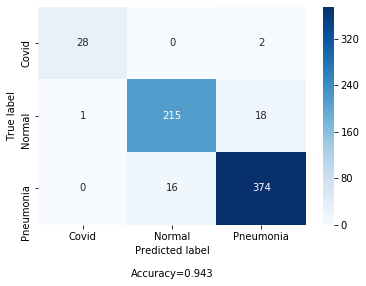

In [149]:
make_confusion_matrix(cn_best, categories=categories,percent=False)

## merge metrics from different runs

In [ ]:
4,3,5

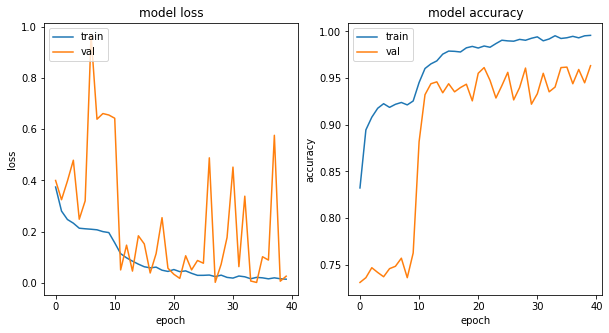

In [154]:
plt.figure(figsize=(10,5))
# summarize history for loss
plt.subplot(121)
plt.plot(hist4.history['loss'] + hist3.history['loss'] + hist5.history['loss'])
plt.plot(hist4.history['val_loss'] + hist3.history['val_loss'] + hist5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#     plt.show()
plt.subplot(122)
# summarize history for accuracy
plt.plot(hist4.history['accuracy'] + hist3.history['accuracy'] + hist5.history['accuracy'])
# plt.plot(history.history['accuracy'])
plt.plot(hist4.history['val_accuracy'] + hist3.history['val_accuracy'] + hist5.history['val_accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [161]:
def moving_avg(numbers, window_size=3):    
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

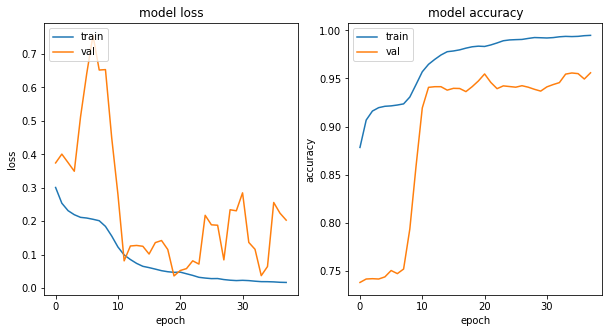

In [162]:
plt.figure(figsize=(10,5))
# summarize history for loss
plt.subplot(121)
plt.plot(moving_avg(hist4.history['loss'] + hist3.history['loss'] + hist5.history['loss']))
plt.plot(moving_avg(hist4.history['val_loss'] + hist3.history['val_loss'] + hist5.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#     plt.show()
plt.subplot(122)
# summarize history for accuracy
plt.plot(moving_avg(hist4.history['accuracy'] + hist3.history['accuracy'] + hist5.history['accuracy']))
# plt.plot(history.history['accuracy'])
plt.plot(moving_avg(hist4.history['val_accuracy'] + hist3.history['val_accuracy'] + hist5.history['val_accuracy']))
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [163]:
cn_best

array([[ 28,   0,   2],
       [  1, 215,  18],
       [  0,  16, 374]])

In [166]:
# y_actual, y_test
keras.utils.to_categorical(y_actual, num_classes=3).shape

(654, 3)

# AUC - ROC computations

In [167]:
def eval3(model, path=VAL_PATH):
    y_actual, y_test, y_prob = [],[],[]
    for i in os.listdir(path + "/Normal/"):
        img=image.load_img(path + "/Normal/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_prob.append(pred)
        y_test.append(np.argmax(pred[0]))
        y_actual.append(1)


    for i in os.listdir(path + "/Covid/"):
        img=image.load_img(path + "/Covid/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_prob.append(pred)
        y_test.append(np.argmax(pred[0]))
        y_actual.append(0)
    
    for i in os.listdir(path + "/Pneumonia/"):
        img=image.load_img(path + "/Pneumonia/"+i,target_size=(224,224))
        img=image.img_to_array(img)/255.0
        img=np.expand_dims(img,axis=0)
        # pred=model.predict_classes(img)
        pred=model.predict(img)
        y_prob.append(pred)
        y_test.append(np.argmax(pred[0]))
        y_actual.append(2)
        
    y_actual=np.array(y_actual)
    y_test=np.array(y_test)
    cn=confusion_matrix(y_actual,y_test)
    return cn, y_actual, y_test, y_prob

In [168]:
_,y_actual,y_test,y_prob=eval3(best_model, path=VAL_PATH)

In [194]:
import auc_utils
import importlib
importlib.reload(auc_utils)

<module 'auc_utils' from '/home/akasarla/COGS_225/tCheXNet/auc_utils.py'>

In [180]:
y_actual_onehot = keras.utils.to_categorical(y_actual, num_classes=3)
y_prob = np.array(y_prob).squeeze()

In [181]:
y_actual_onehot.shape, y_prob.shape

((654, 3), (654, 3))

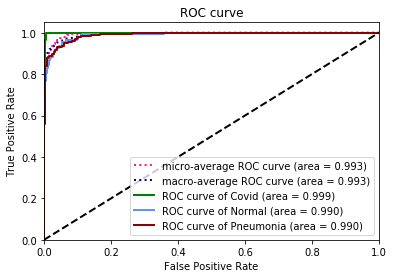

In [195]:
auc_utils.plot_ROC_curve(y_actual_onehot, y_prob, categories, 'models/roc')

In [199]:
cn_train,y_actual,y_test,y_prob=eval3(best_model, path=TRAIN_PATH)

In [200]:
y_actual_onehot = keras.utils.to_categorical(y_actual, num_classes=3)
y_prob = np.array(y_prob).squeeze()
y_actual_onehot.shape, y_prob.shape

((5328, 3), (5328, 3))

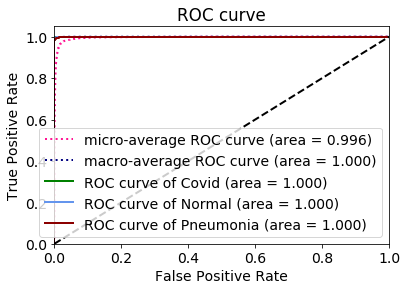

In [201]:
auc_utils.plot_ROC_curve(y_actual_onehot, y_prob, categories, 'models/roc_train')

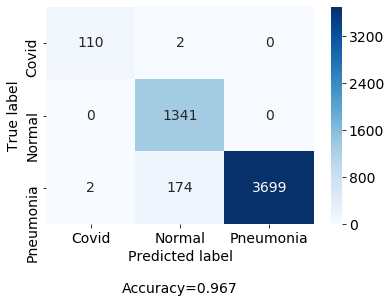

In [204]:
make_confusion_matrix(cn_train, categories=categories,percent=False)

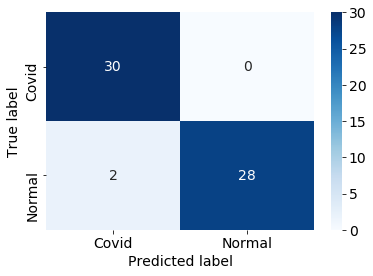

In [210]:
make_confusion_matrix(np.array([[30, 0], [2, 28]]), categories=categories[0:2],percent=False,sum_stats=False)